### Let us import the necessary libraries we need 

In [1]:
import numpy as np
import pandas as pd
import os
import argparse
import time
import math
import random
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import gzip
import pickle
import numpy as np
from torch.autograd import Variable
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import torchsnooper

from tqdm import tqdm

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Define some useful functions that are needed repeatedly

In [2]:
def read_pickle_file(pickle_file_name):
    """reads a pickle file containing different parameters: 'avse','run','energy','detector','tDrift','wf','tstart','period','t0' saved in dictionary 
    and reuturns the list of those parameter"""
    objects = []
    with (open(pickle_file_name,"rb")) as depfile:
        while True:
            try:
                objects.append(pickle.load(depfile))
            except EOFError:
                break
    return objects

def baselinecorre_norm(wf, sample_range):
    '''Does a baseline correction and then normalization to a given waveform taking samples 
    provided by sample_range'''
    baseline = np.mean(wf[:sample_range])
    wf_bc = wf - baseline
    wf_norm = (wf_bc - np.min(wf_bc)) / (np.max(wf_bc) - np.min(wf_bc)) #rescale wf to between 0 and 1
    return wf_norm

def create_pileup_wf(pickle_file_name, end_shift_param):
    '''creates a single pileup waveform using two normal waveforms selected randomly from a given pickle file'''
    params_list = read_pickle_file(pickle_file_name)
    
    #number of wfs saved in a pickle file
    high_value = len(params_list)
    
    #choose randomly a single waveform from the pickle file
    choose = np.random.randint(1, high_value-1)
    
    #choose a single waveform (Base waveform)
    wfBs = params_list[choose]["wf"]
    
    #choose another single waveform (onTop waveform)
    wfOt = params_list[choose+1]["wf"]
    
    # Do the baseline correction and normalization
    wfBs = baselinecorre_norm(wfBs,960) #960 is because most of the single wfs have t0 around 960
    wfOt = baselinecorre_norm(wfOt,960)
    
    #randomize the base_wf and on_top_wf
    wfBs = wfBs*np.random.random()
    wfOt = wfOt*np.random.random()
    wf_len = len(wfBs)
    wfBsdf = pd.Series(wfBs)
    wfOtdf = pd.Series(np.zeros(end_shift_param)).append(pd.Series(wfOt),ignore_index=True) #need to be very careful when using ignore_index =True
    wfOtdf = wfOtdf[:wf_len]
    wf_pileup = wfBsdf + wfOtdf
    return wf_pileup
    

### Creating 60k pileup waveforms having the shift between 1ns and 100ns and save these wfs to a pickle file

In [4]:
# create the pileup waveforms and its corresponding shift label
# import time
# start_time = time.time()
# filename = "wf_and_shift_label_regression_60k.pickle"
# with open(filename, 'wb') as handle:
#     for i in range(60000):
#         sft = np.random.randint(1,101)
#         wf_pileup = create_pileup_wf("/home/xu_lab/shared/laxman_test/DEP_608_DS6.pickle",sft)
#         wf = np.array(wf_pileup)
#         event_dict = {"shift":sft,\
#                      "wf":wf}
#         pickle.dump(event_dict,handle, protocol=pickle.HIGHEST_PROTOCOL)
# end_time = time.time()  
# total_time = end_time - start_time
# print("TOTAL time taken : %d seconds"%total_time)


In [19]:
'''
These 2 parameters define the range of waveform we'd like to analyze
'''
LSPAN = 200 # number of time samples prior to t0
HSPAN = 400 # number of time samples after t0

### Defining a WaveformDataset Class 

In [11]:
class WaveformDatasetClass(Dataset):
    def __init__(self, picklefile = "/home/xu_lab/shared/laxman_test/wf_and_shift_label_regression_60k.pickle", transform = None):
        self.pileup_wfs_and_label = self.event_loader(picklefile)
        self.normal_wfs_and_label = self.event_loader("../ml/new731.pickle") # added 731 single wfs from DEP_608_DS6.pickle (contains 5731 wfs) file "
        self.wfs = self.pileup_wfs_and_label + self.normal_wfs_and_label 
        self.all_wfs = random.sample(self.wfs,len(self.wfs)) #shuffle the list
        self.size = len(self.all_wfs)
        self.transform = transform
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        wf = self.all_wfs[idx]["wf"]
       # baseline correction and normalization
        t0 = 960  #looking at many waveforms, found that t0 is around 965, so choosing 960 as a good guess 
        wf -= np.average(wf[:(t0-50)])
        wfbegin = t0 - LSPAN
        wfend = t0 + HSPAN
        wf = wf[wfbegin:wfend]
        wf = (wf - np.min(wf)) / (np.max(wf) - np.min(wf))
        wf = wf.astype("float32")

        shift = self.all_wfs[idx]["shift"]
        return wf, shift 
        
    def event_loader(self, wf_and_label_file):
        objects = []
        with (open(wf_and_label_file,"rb")) as wffile:
            while True:
                try:
                    objects.append(pickle.load(wffile))
                except EOFError:
                    break
        return objects

### Defining another class that will be used for testing Single/Normal waveforms in network

In [12]:
class NormalWaveformTestClass(Dataset):
    def __init__(self, normalWf_file = "/home/xu_lab/shared/laxman_test/DEP_608_DS6.pickle",test_above_index = 731):
        # reason for choosing 731 is that the first 731 single wfs are already used in WaveformDatasetClass()
        self.normal_wfs = self.event_loader(normalWf_file) 
        self.test_above_index = test_above_index
        self.size = len(self.normal_wfs[self.test_above_index:])

        
    def __len__(self):
        return self.size
    
    def __getitem__(self,idx):
        wf = self.normal_wfs[self.test_above_index+idx]["wf"]
       # baseline correction and normalization
        t0 = 960  
        wf -= np.average(wf[:(t0-50)])
        wfbegin = t0 - LSPAN
        wfend = t0 + HSPAN
        wf = wf[wfbegin:wfend]
        wf = (wf - np.min(wf)) / (np.max(wf) - np.min(wf))
        wf = wf.astype("float32")
        shift = 0 # shift is always 0 for single wfs
        return wf, shift
    def event_loader(self, normal_wf_file):
        objects = []
        with (open(normal_wf_file,"rb")) as wffile:
            while True:
                try:
                    objects.append(pickle.load(wffile))
                except EOFError:
                    break
        return objects

In [13]:
#Load dataset
def load_data(batch_size):
    train_data = WaveformDatasetClass()
    test_data = NormalWaveformTestClass()
    train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, drop_last=True)
    test_loader = data_utils.DataLoader(test_data, batch_size=batch_size, drop_last=True)

    return train_loader,test_loader

#### Define Hyperparameters:

In [67]:
BATCH_SIZE = 40
NUM_EPOCHS = 100
LEARNING_RATE =1e-3

### Defining a RNN model and fully connected part

In [68]:
#The fully connected part of neural network
class FCNet(nn.Module):
    def __init__(self, first_unit, last_unit):
        super(FCNet, self).__init__()
        
        #Number of channels in each fully connected layers
        fc1, fc2, fc3, fc4 = (first_unit, int(first_unit*0.5), int(first_unit*0.25), int(first_unit*0.1))
        do = 0.2
        self.fcnet = nn.Sequential(
            torch.nn.Linear(fc1, fc2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(do),
            torch.nn.Linear(fc2, fc3),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(do),
            torch.nn.Linear(fc3, fc4),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(do),
            torch.nn.Linear(fc4, last_unit),
        )
    def forward(self, x):
        return self.fcnet(x)

#The RNN based model:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        feed_in_dim = 955
        self.seq_len = 600
        self.seg = 1 #1200 
        self.RNNLayer = torch.nn.GRU(input_size = self.seg, hidden_size = feed_in_dim//2, batch_first=True)
        self.fcnet = FCNet(feed_in_dim//2,1)
#     @torchsnooper.snoop()
    def forward(self, x):
        x = x.view(-1,self.seq_len,self.seg)
        output, hidden = self.RNNLayer(x)
        hidden =  hidden[-1]
        x = self.fcnet(hidden) 
        return x



In [69]:
#Load data
train_loader, test_loader = load_data(BATCH_SIZE)

In [ ]:
loss_values = []
rmse_values = []

#Define RNN network
classifier = RNN()

classifier.to(DEVICE)

print("#params", sum(x.numel() for x in classifier.parameters()))

criterion = torch.nn.MSELoss()
criterion = criterion.to(DEVICE)

optimizer = torch.optim.RMSprop(classifier.parameters(),lr=LEARNING_RATE)

for epoch in tqdm(range(NUM_EPOCHS)):
    for i, (waveform, labels) in enumerate(train_loader):
        classifier.train()
        waveform = waveform.to(DEVICE)
        labels = labels.to(DEVICE).float()
        outputs  = classifier(waveform).reshape([BATCH_SIZE]) # adjusting with the size of labels
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()        
        optimizer.zero_grad()  
        
    print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
        epoch+1, NUM_EPOCHS, i+1, len(train_loader),
        loss.item(), end=""),end="")
    print("")
    loss_values.append(loss.item())
    
    y_true = []
    y_pred = []
    cont_error = [] 
    #After every epoch, evaluate the validation accuracy on the test loader
    for waveform,labels in test_loader:
        classifier.eval() 
        with torch.no_grad():
            waveform = waveform.to(DEVICE)
            outputs  = classifier(waveform)
            y_true += list(labels)
            y_pred += list(outputs)
    # Calculate the separation between true shift and predicted shift        
    for j in range(len(y_true)):
        cont_error.append(y_pred[j].item() - y_true[j].item())
    
    rmse = np.sqrt(np.mean(np.square(cont_error)))
    rmse_values.append(rmse)
    print("rmse value is", rmse)

#### save the separation between true shift and predicted shift to a txt file

In [73]:
file = np.savetxt("separation_Value_singleWFs_RNN_regression.txt",(cont_error))

#### read the txt file and make a histogram of distribution of separation

In [100]:
separation = np.loadtxt("separation_Value_singleWFs_RNN_regression.txt")

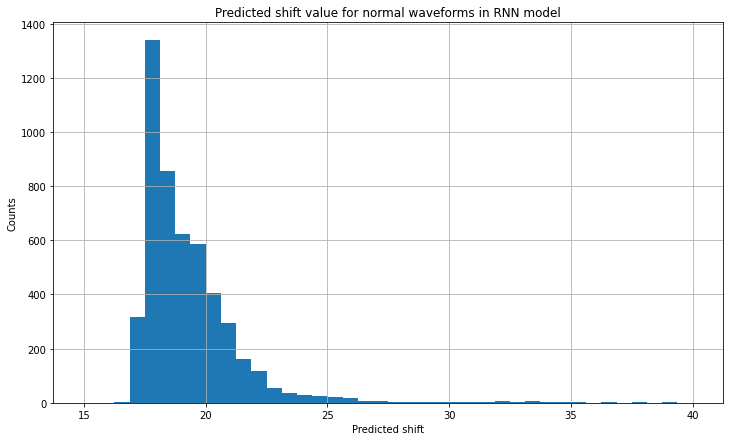

In [102]:
plt.figure(figsize=(12,7))
plt.hist(separation, bins = 40, range = (15,40),log = False)
plt.xlabel("Predicted shift")
plt.title("Predicted shift value for normal waveforms in RNN model")
plt.ylabel("Counts")
plt.grid()
plt.show()

### Fit the distribution with Gaussian

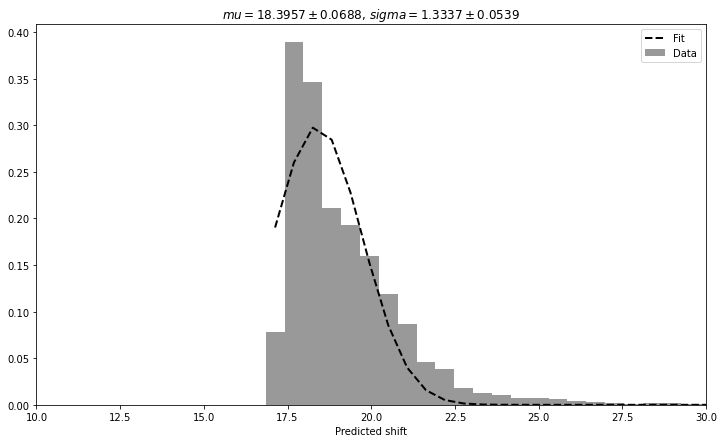

In [104]:
import scipy
from scipy.optimize import curve_fit
from scipy.stats import norm

x = separation
fig, ax = plt.subplots(figsize=(12,7)) 
nbins = 120
n, bins, patches = ax.hist(x,nbins, density=True, facecolor = 'grey', alpha = 0.8, label='Data'); 

centers = (0.5*(bins[1:]+bins[:-1]))
pars, cov = curve_fit(lambda x, mu, sig : norm.pdf(x, loc=mu, scale=sig), centers, n, p0=[20,5])

ax.plot(centers, norm.pdf(centers,*pars), 'k--',linewidth = 2, label='Fit') 
ax.set_title('$mu={:.4f}\pm{:.4f}$, $sigma={:.4f}\pm{:.4f}$'.format(pars[0],np.sqrt(cov[0,0]), pars[1], np.sqrt(cov[1,1 ])))
plt.xlabel("Predicted shift")
plt.xlim(10,30)
plt.legend()
plt.show()

#### plot the RMSE vs Epochs

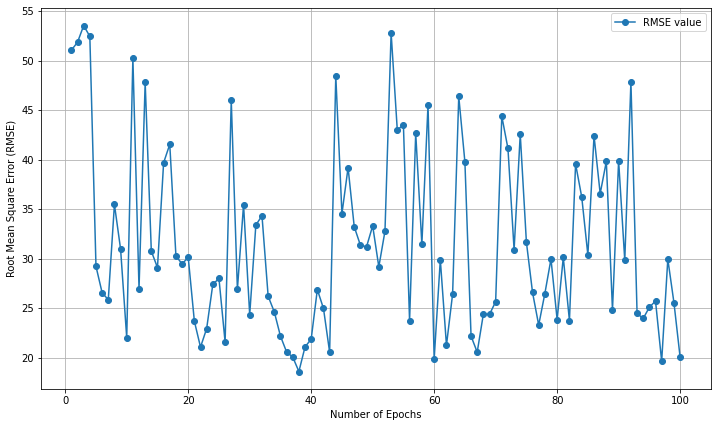

In [96]:
plt.figure(figsize=(12,7))
plt.plot(np.linspace(1,100,100),rmse_values, marker="o",label="RMSE value")
plt.xlabel("Number of Epochs")
plt.ylabel("Root Mean Square Error (RMSE)")
# plt.xlim(0,50)
plt.grid()
plt.legend()
plt.show()